# Binary Classification Prediction Pipeline
This notebook:
- Loads train/test data
- Explores class balance
- Preprocesses features (cleaning, encoding, imputation)
- Trains gradient-boosted model with fallback
- Handles class imbalance
- Evaluates with cross-validation (AUC/accuracy)
- Tunes threshold and outputs predictions
- Saves pipeline and predictions

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt
import os


In [9]:
# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (2698, 12)
Test shape: (302, 11)


In [12]:
test_df

,customer_id,age,income,signup_channel,country,account_duration,last_login_days,num_transactions,support_tickets,premium_user,satisfaction_score
0,CUST102698,27,48133.59,APP,US,27,NaN,7,1,Y,5.0
1,CUST102699,46,41464.59,Referral,Canada,53,NaN,10,0,N,1.0
2,CUST102700,27,41684.93,app,India,2,167.0,16,2,No,1.0
3,CUST102701,29,79099.83,web,US,34,144.0,13,3,Y,3.0
4,CUST102702,47,38870.25,APP,US,31,185.0,14,0,YES,5.0
...,...,...,...,...,...,...,...,...,...,...,...
297,CUST102995,37,26426.33,APP,India,1,NaN,9,3,NO,1.0
298,CUST102996,21,38093.20,web,Canada,19,277.0,15,1,Y,1.0
299,CUST102997,71,52240.34,Referral,Germany,46,55.0,9,0,YES,2.0
300,CUST102998,24,46921.57,app,Germany,3,273.0,14,0,No,3.0


In [13]:
# Target distribution
print("Target value counts:")
print(train_df['target'].value_counts())
print("\nNormalized:")
print(train_df['target'].value_counts(normalize=True))

Target value counts:
target
0    1881
1     817
Name: count, dtype: int64

Normalized:
target
0    0.697183
1    0.302817
Name: proportion, dtype: float64


In [14]:
# Drop identifier and clean
train_df = train_df.copy()
test_df = test_df.copy()
test_ids = test_df['customer_id']

train_df = train_df.drop(columns=['customer_id'])
test_df = test_df.drop(columns=['customer_id'])

def clean_text(s):
    if pd.isna(s):
        return s
    return s.strip().lower()

for col in ['signup_channel', 'premium_user']:
    train_df[col] = train_df[col].apply(clean_text)
    test_df[col] = test_df[col].apply(clean_text)

train_df['premium_user'] = train_df['premium_user'].replace({'yes':'y','y':'y','no':'n','n':'n'})
test_df['premium_user'] = test_df['premium_user'].replace({'yes':'y','y':'y','no':'n','n':'n'})

# Features
target = 'target'
categorical_cols = ['signup_channel', 'country', 'premium_user']
numeric_cols = [c for c in train_df.columns if c not in categorical_cols + [target]]

# Preprocessing pipeline
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [15]:
# Model with fallback and class imbalance handling
def get_model(scale_pos_weight=None):
    try:
        import lightgbm as lgb
        params = {
            'n_estimators': 1000,
            'learning_rate': 0.05,
            'random_state': 42,
            'objective': 'binary',
            'importance_type': 'gain'
        }
        if scale_pos_weight is not None:
            params['is_unbalance'] = False
            params['scale_pos_weight'] = scale_pos_weight
        model = lgb.LGBMClassifier(**params)
    except ImportError:
        # fallback
        model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42, n_jobs=-1)
    return model

# Compute class imbalance ratio
y = train_df[target]
neg = (y==0).sum()
pos = (y==1).sum()
print(f"Class counts: 0={neg}, 1={pos}, ratio (neg/pos)={neg/pos:.2f}")

Class counts: 0=1881, 1=817, ratio (neg/pos)=2.30


In [16]:
# Cross-validation evaluation
X = train_df.drop(columns=[target])
y = train_df[target]

scale_pos_weight = None
# If using LightGBM, set scale_pos_weight to counter class imbalance
try:
    import lightgbm as lgb
    scale_pos_weight = neg / pos if pos > 0 else 1.0
except ImportError:
    pass

model = get_model(scale_pos_weight=scale_pos_weight)

pipeline = Pipeline([('preproc', preprocessor), ('clf', model)])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
acc_scores = []
all_probs = []
all_targets = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    pipeline.fit(X_train, y_train)
    proba = pipeline.predict_proba(X_val)[:,1]
    pred_label = (proba >= 0.5).astype(int)
    auc = roc_auc_score(y_val, proba)
    acc = accuracy_score(y_val, pred_label)
    auc_scores.append(auc)
    acc_scores.append(acc)
    all_probs.append(proba)
    all_targets.append(y_val.values)
    print(f"Fold {fold}: AUC={{auc:.4f}}, Accuracy={{acc:.4f}}".format(auc=auc, acc=acc))

print(f"Mean AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"Mean Accuracy: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")

Fold 1: AUC=0.4576, Accuracy=0.6944
Fold 2: AUC=0.5052, Accuracy=0.6944
Fold 3: AUC=0.5252, Accuracy=0.7019
Fold 4: AUC=0.4645, Accuracy=0.6939
Fold 5: AUC=0.4856, Accuracy=0.6920
Mean AUC: 0.4876 ± 0.0251
Mean Accuracy: 0.6953 ± 0.0034


Best threshold by F1: 0.108, F1: 0.4651


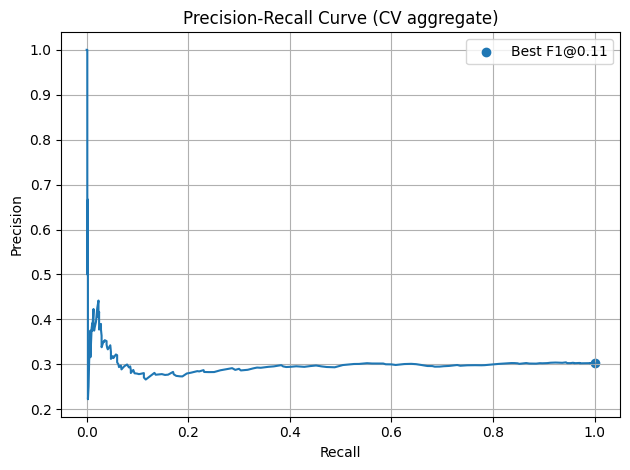

In [17]:
# Threshold tuning via precision-recall curve (on aggregated CV)
probs = np.concatenate(all_probs)
targets = np.concatenate(all_targets)
precisions, recalls, thresholds = precision_recall_curve(targets, probs)

# Compute F1 for thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx = np.nanargmax(f1_scores)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
print(f"Best threshold by F1: {best_threshold:.3f}, F1: {f1_scores[best_idx]:.4f}")

# Plot Precision-Recall curve
plt.figure()
plt.plot(recalls, precisions)
plt.scatter(recalls[best_idx], precisions[best_idx], label=f"Best F1@{best_threshold:.2f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (CV aggregate)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Final training on all data and prediction
pipeline.fit(X, y)
test_X = test_df.copy()
test_proba = pipeline.predict_proba(test_X)[:,1]
test_pred = (test_proba >= best_threshold).astype(int)

# Save output
output = pd.DataFrame({
    'customer_id': test_ids,
    'prediction': test_pred,
    'prediction_proba': test_proba
})
output.to_csv('test_predictions.csv', index=False)
print('Saved predictions to test_predictions.csv')


Saved predictions to test_predictions.csv


In [20]:
pd.read_csv('test_predictions.csv').head()

,customer_id,prediction,prediction_proba
0,CUST102698,1,0.222
1,CUST102699,1,0.286
2,CUST102700,1,0.376
3,CUST102701,1,0.142
4,CUST102702,1,0.308
